# Head Detection among images

reference : https://kapernikov.com/tutorial-image-classification-with-scikit-learn/

In [1]:
# loading libraries
# System
import os
import joblib
from collections import Counter



# Image processing
import skimage
from skimage.transform import resize
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

# Data Processing
import numpy as np
import pandas as pd

# data viz
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# Preparing the data set

In [2]:
data_path = r'Image'

print(os.listdir(data_path))

['BearHead', 'CatHead', 'ChickenHead', 'CowHead', 'DeerHead', 'DogHead', 'DuckHead', 'EagleHead', 'ElephantHead', 'HumanHead', 'LionHead', 'MonkeyHead', 'MouseHead', 'PandaHead', 'PigeonHead', 'PigHead', 'RabbitHead', 'SheepHead', 'TigerHead', 'WolfHead']


Nombre de labels : all animals

In [3]:
# load functions and classes
from resizedata import resize_data
from transformers import RGB2GrayTransformer, HogTransformer

base_name = 'animal_faces'
width = 80

include = os.listdir(data_path)

resize_data(src=data_path, pklname=base_name, include=include, width=width)

BearHead
CatHead
ChickenHead
CowHead
DeerHead
DogHead
DuckHead
EagleHead
ElephantHead
HumanHead
LionHead
MonkeyHead
MouseHead
PandaHead
PigeonHead
PigHead
RabbitHead
SheepHead
TigerHead
WolfHead


Let’s load the data from disk and print a summary.

In [4]:
from collections import Counter
 
data = joblib.load(f'Output/{base_name}_{width}x{width}px.pkl')

# data2 = joblib.load(f'Output/{pklname2}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  2016
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80)animal images in rgb
image shape:  (80, 80, 3)
labels: ['Bear' 'Cat' 'Chicken' 'Cow' 'Deer' 'Dog' 'Duck' 'Eagle' 'Elephant'
 'Human' 'Lion' 'Monkey' 'Mouse' 'Panda' 'Pig' 'Pigeon' 'Rabbit' 'Sheep'
 'Tiger' 'Wolf']


Counter({'Bear': 101,
         'Cat': 107,
         'Chicken': 100,
         'Cow': 101,
         'Deer': 101,
         'Dog': 101,
         'Duck': 102,
         'Eagle': 97,
         'Elephant': 100,
         'Human': 100,
         'Lion': 97,
         'Monkey': 100,
         'Mouse': 100,
         'Panda': 101,
         'Pigeon': 97,
         'Pig': 101,
         'Rabbit': 99,
         'Sheep': 100,
         'Tiger': 111,
         'Wolf': 100})

The images below show an example of each animal included.

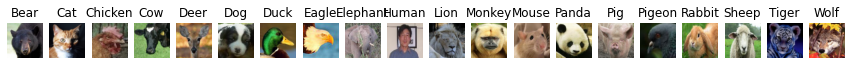

In [5]:
labels = np.unique(data['label'])

fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,15)
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

By convention, we name the input data X and result (labels) y.

In [6]:
# l = []
# for i in range(0, len(data['data'])):
#     if data['data'][i].shape != (80, 80, 3):
#         l.append(i)

In [7]:
X = np.array(data['data'])

y = np.array(data['label'])

# Training & test dataset
![title](assets/scikit-training-test.webp)

In [8]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
    stratify=y)

To verify that the distribution of photos in the training and test set is similar, let’s look at the relative number of photos per category.

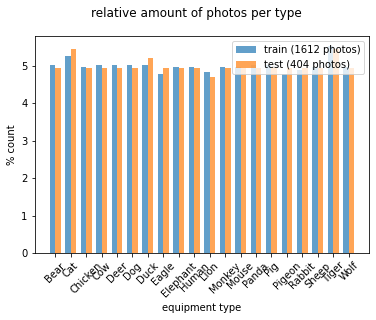

In [9]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

# Processing

A classic approach to object recognition is HOG-SVM, which stands for Histogram of Oriented Gradients and Support Vector Machines. HOGs are used for feature reduction, in other words: for lowering the complexity of the problem, while maintaining as much variation as possible.

To calculate a HOG, an image is divided into blocks, for example 8 by 8 pixels. For each of these blocks, the magnitude of the gradient in a given number of directions is calculated. For a detailed explanation, we refer to http://www.learnopencv.com/histogram-of-oriented-gradients/.

Here we will just look at an example:

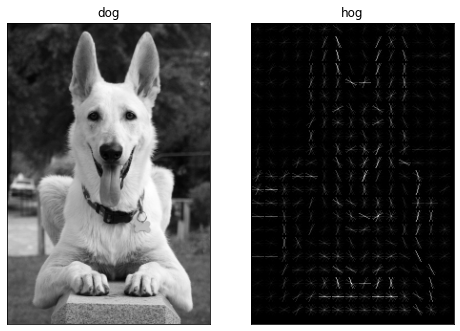

In [10]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
dog = imread('assets/White_German_Shepherd_Dog_Posing.jpg', as_gray=True)
# https://en.wikipedia.org/wiki/German_Shepherd#/media/File:Kim_at_14_weeks.jpg
 
# scale down the image to one third
dog = rescale(dog, 1/3, mode='reflect')
# calculate the hog and return a visual representation.
dog_hog, dog_hog_img = hog(
    dog, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(dog, cmap='gray')
ax[0].set_title('dog')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [11]:
print('number of pixels: ', dog.shape[0] * dog.shape[1])
print('number of hog features: ', dog_hog.shape[0])

number of pixels:  67308
number of hog features:  10584


The number of data points to process in our model has been reduced to ~15%, and with some imagination we can still recognise a dog in the HOG.

# Transformers

When calculating our HOG, we performed a transformation. We can transform our entire data set using transformers. These are objects that take in the array of data, transform each item and return the resulting data.

Here, we need to convert colour images to grayscale, calculate their HOGs and finally scale the data. For this, we use three transformers in a row: RGB2GrayTransformer, HOGTransformer and StandardScaler. The final result is an array with a HOG for every image in the input.

Scikit-learn comes with many built-in transformers, such as a StandardScaler to scale features and a Binarizer to map string features to numerical features. In addition, it provides the BaseEstimator and TransformerMixin classes to facilitate making your own Transformers.

A custom transformer can be made by inheriting from these two classes and implementing an __init__, fit and transform method. The TransformerMixin class provides the fit_transform method, which combines the fit and transform that we implemented.

Below, we define the RGB2GrayTransformer and HOGTransformer.

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

Note that for compatibility with scikit-learn, the fit and transform methods take both X and y as parameters, even though y is not used here.

With this, we are all set to preprocess our RGB images to scaled HOG features.

In [13]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(1612, 576)


# Training

The next step is to train a classifier. We will start with Stochastic Gradient Descent (SGD), because it is fast and works reasonably well.

First we create an instance and then we call the fit method passing our training data and labels.

In [14]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=0.02)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42, tol=0.02)

# Testing


To test the trained SGD classifier, we will use our test set. First, we transform it using the same transformers as before. However, we must take care that our test data will not influence the transformers. Some transformers, like PCA (Principle Component Analysis), can optimise themselves on the data before applying the transformation. To prevent this, we call transform and not fit_transform on the test data.



In [15]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

Next, we make a prediction for our test set and look at the results. How many of the predictions match with y_test?

In [16]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True  True False  True  True  True False False  True False  True  True
 False  True  True False  True False False  True False False  True False
  True]

Percentage correct:  66.33663366336634


# Confusion matrix

A percentage like the above is nice, but it is not the whole story. What about false positives, for example? To get more insight in the results, we can use a correlation matrix. This is a table where each row corresponds to a label, and each column to a prediction.

We will illustrate this using a pandas dataframe with some yes/no data.

In [17]:
import pandas as pd

In [18]:
labels = ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no',  'no', 'no', 'no']
predictions = ['yes', 'yes', 'yes', 'yes', 'no',  'no',  'yes', 'no', 'no', 'no']
 
# put the data in a dataframe for pretty printing
df = pd.DataFrame(
    np.c_[labels, predictions], 
    columns=['true_label', 'prediction']
)
df

,true_label,prediction
0,yes,yes
1,yes,yes
2,yes,yes
3,yes,yes
4,yes,no
5,yes,no
6,no,yes
7,no,no
8,no,no
9,no,no


To create a confusion matrix, we use the confusion_matrix function from sklearn.metrics. Besides the two lists we created above, we also pass a labels array with the values of the labels. This is only to control the order in which they appear in the matrix. If we leave this out, they would appear sorted alphabetically. The columns give us the predictions, while along the index, we find the real labels.

In [19]:
from sklearn.metrics import confusion_matrix
 
label_names = ['yes', 'no']
cmx = confusion_matrix(labels, predictions, labels=label_names)
df = pd.DataFrame(cmx, columns=label_names, index=label_names)
df.columns.name = 'prediction'
df.index.name = 'label'
df

prediction,yes,no
label,,
yes,4,2
no,1,3


The main diagonal corresponds to correct predictions. In this binary case, false positives show up below and false negatives above the diagonal.

Another way to represent this is in the form of a colormap image.

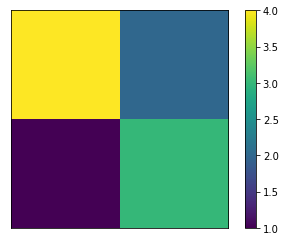

In [20]:
plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar();

The confusion matrix for the SGD test is a 8×8 matrix. As above, correct predictions appear on the main diagonal, whereas all off-diagonal values correspond to incorrect classifications.

In [21]:
cmx = confusion_matrix(y_test, y_pred)
cmx

array([[13,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  3,  0,
         0,  0,  1,  0],
       [ 1, 15,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,
         0,  0,  0,  1],
       [ 0,  0, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
         1,  0,  1,  0],
       [ 0,  1,  1, 10,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
         2,  3,  1,  0],
       [ 0,  2,  0,  0, 16,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0],
       [ 1,  0,  0,  0,  0,  8,  0,  1,  0,  2,  2,  2,  0,  0,  2,  0,
         0,  2,  0,  0],
       [ 0,  2,  2,  0,  0,  0, 10,  2,  1,  0,  0,  0,  0,  0,  0,  1,
         1,  1,  1,  0],
       [ 0,  0,  3,  0,  0,  0,  1, 12,  0,  0,  0,  2,  0,  1,  0,  1,
         0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  1,  0, 14,  0,  2,  0,  2,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 1,  1,  1,  0,  0,  2

The largest values are on the diagonal, hence most predictions are correct, but there are mistakes (~15%). To visualise this more clearly as an image, we do two things. First, we normalise the matrix to 100, by dividing every value by the sum of its row (i.e. the number of actual items with a specific label). Second, we set the main diagonal to 0 in order to focus on the wrong predictions.


 ['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle', 'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Panda', 'Pig', 'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf']


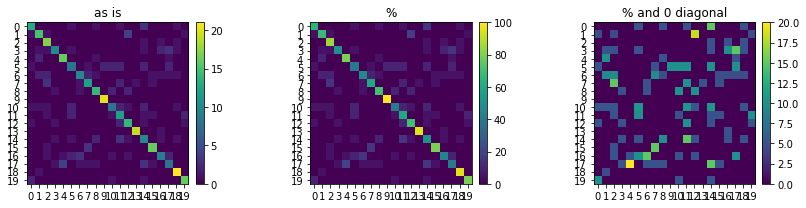

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))

To draw proper conclusions, we often need to combine what we see in the confusion matrix with what we already know about the data. For example, we have quite a high percentage of eagles being classified as chickens. No offense to either eagles or chickens, but within this set they are similar. Also not all photos are very clear, perhaps we could look into different feature extraction methods or use a bit higher resolution images.

# Optimisation


An 85% score is not bad for a first attempt and with a small dataset, but it can most likely be improved. As we already have a bunch of parameters to play with, it would be nice to automate the optimisation. In the next bit, we’ll set up a pipeline that preprocesses the data, trains the model and allows us to play with parameters more easily.

The pipeline fit method takes input data and transforms it in steps by sequentially calling the fit_transform method of each transformer. The data is passed from output to input until it reaches the end or the estimator if there is one. When the last item in the pipeline is an estimator, its fit method is called to train the model using the transformed data.

The resulting object can be used directly to make predictions. Test data is passed into the predict method, which calls the transform methods, followed by predict in the final step.

A run with our system shows that the result of the pipeline is identical to the result we had before.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', Normalizer()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))


Percentage correct:  67.07920792079207


# Grid search

A huge advantage here is that, by using our pipeline, we can optimise both the transformations and the classifier in a single procedure. Additionally, instead of manually modifying parameters, we will use GridSearchCV. First we define a parameter grid, as shown in the cell below.

Transformers and estimators are indicated by their name, such as ‘classify’. Their parameters are indicated by ‘name__parameter’. Our parameter grid consists of two dictionaries. In the first, we try to improve the HOGTransformer. In the second, we test SGD vs. SVM. GridSearchCV will check all combinations within each dictionary, so we will have, 2 * 2 * 3 + 2 = 14, in total. Since the optimal preprocessing can vary with the model, it is often a good idea to gridsearch them together to find the global optimum. So, a better grid would be one where the hogify and classify settings are varied together (by placing them in a single dictionary).

In [24]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {
         'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear', probability=True)
         ]
    }
]

Next, we create a GridSearchCV object, passing the pipeline, and parameter grid. In addition we use cv=3. This parameter sets up cross validation. This means the data set is split into folds (3 in this case) and multiple training runs are done. In each run, one fold is used for validation and the others for training. This way the model can be validated and improved against a part of the training data, without touching the test data. For the final parameter, the score, we use ‘accuracy’, the percentage of true positive predictions. In other cases it might be more useful to use check false positives or another statistic.

The n_jobs parameter specifies the number of jobs we wish to run in parallel. We set its value to -1 to use all available cores. Note that this works in notebooks in Linux and possible OSX, but not in MS Windows.

To parallelise under Windows, it is necessary to run this code from a script, inside an if __name__ == ‘__main__’ clause. Further explanation can be found in the joblib documentation.

In [25]:
if __name__ == "__main__":
    grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
    grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


When the grid search is complete, the model will be trained a final time, using the full training set and the optimal parameters. We can dump the resulting object into a pickle file and load it when we want to use it. We can also use various methods to poke around in the results and the scores during the search. Note the trailing underscore in the properties: this is a scikit-learn convention, used for properties that only came into existence after a fit was performed.

In [26]:
# save the model to disk
joblib.dump(grid_res, 'Output/hog_sgd_model.pkl');

In [27]:
# description of the best performing object, a pipeline in our case.
grid_res.best_estimator_

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', Normalizer()),
                ('classify', SVC(kernel='linear', probability=True))])

In [28]:
from sklearn.svm import SVC
Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', SVC(kernel='linear', probability=True))])

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', SVC(kernel='linear'))])

Additionally, run grid_res.cv_results_  to a get a detailed log of the gridsearch. The output is not shown here, as it is quite long. To be able to retrieve this log in sklearn version 0.21 and up, the return_train_score argument of GridSearchCV must be set to True.

In [29]:
# the highscore during the search
grid_res.best_score_

0.7444105233766923

In [30]:
print(grid_res.best_params_)

{'classify': SVC(kernel='linear', probability=True), 'hogify__cells_per_block': (3, 3), 'hogify__orientations': 8, 'hogify__pixels_per_cell': (8, 8)}


Because the number of runs tends to explode quickly during a grid search, it is sometimes useful to use RandomizedSearchCV. This works in the same way as the grid search, but picks a specified (n_iter) number of random sets of parameters from the grid. This can be a good way to obtain a rough estimate of optimal parameters, before using a GridSearchCV for fine tuning.

Going back to our GridSearchCV results, our best results were obtained with a linear SVM. As a final test we use the model to make predictions for our test set, like we did above

In [31]:
best_pred = grid_res.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  80.44554455445545


In [32]:
cmx_svm = confusion_matrix(y_test, best_pred)

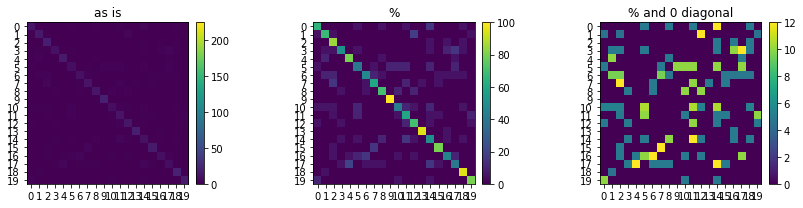

In [33]:
plot_confusion_matrix(cmx, vmax1=225, vmax2=100, vmax3=12)

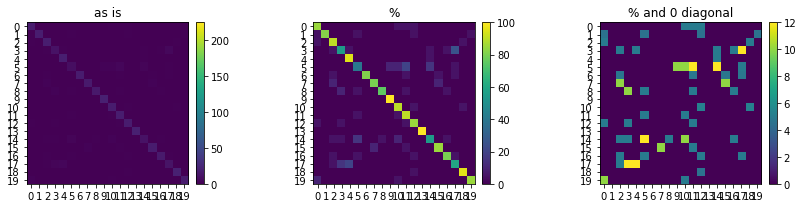

In [34]:
plot_confusion_matrix(cmx_svm, vmax1=225, vmax2=100, vmax3=12)

On the far right, we can see where improvements took place (we turned chickens into eagles, it seems). Now we can try to look for specific issues in the data or perform feature extraction for further improvement. Fortunately, with the toolkit we built, we can let the computer do a fair amount of this work for us.

# Conclusion

In conclusion, we built a basic model to classify images based on their HOG features. In addition, we set up our tooling to systematically improve the model in an automated way. And most importantly, this methodology is generic and can be applied to all kinds of machine learning problems.

In [35]:
from sklearn.metrics import accuracy_score
print("Accuracy: "+str(accuracy_score(y_test, best_pred)))
print('\n')
print(classification_report(y_test, best_pred))

['Wolf' 'Eagle' 'Elephant' 'Elephant' 'Monkey' 'Duck' 'Dog' 'Elephant'
 'Panda' 'Duck' 'Eagle' 'Lion' 'Panda' 'Pig' 'Wolf' 'Eagle' 'Tiger'
 'Chicken' 'Sheep' 'Deer' 'Cat' 'Pig' 'Human' 'Monkey' 'Panda' 'Tiger'
 'Bear' 'Duck' 'Human' 'Cat' 'Pigeon' 'Cow' 'Human' 'Monkey' 'Pigeon'
 'Dog' 'Dog' 'Duck' 'Elephant' 'Elephant' 'Cow' 'Mouse' 'Panda' 'Lion'
 'Duck' 'Wolf' 'Wolf' 'Panda' 'Bear' 'Pig' 'Cow' 'Cat' 'Human' 'Lion'
 'Mouse' 'Sheep' 'Pig' 'Deer' 'Pigeon' 'Panda' 'Panda' 'Pig' 'Eagle'
 'Mouse' 'Chicken' 'Chicken' 'Elephant' 'Sheep' 'Duck' 'Lion' 'Monkey'
 'Rabbit' 'Wolf' 'Tiger' 'Lion' 'Sheep' 'Sheep' 'Eagle' 'Lion' 'Chicken'
 'Sheep' 'Wolf' 'Sheep' 'Cow' 'Rabbit' 'Lion' 'Dog' 'Elephant' 'Eagle'
 'Human' 'Panda' 'Dog' 'Cat' 'Bear' 'Tiger' 'Rabbit' 'Cow' 'Dog' 'Sheep'
 'Rabbit' 'Bear' 'Cat' 'Dog' 'Pig' 'Bear' 'Tiger' 'Bear' 'Monkey' 'Rabbit'
 'Elephant' 'Cow' 'Eagle' 'Cat' 'Duck' 'Mouse' 'Deer' 'Rabbit' 'Cow' 'Pig'
 'Cow' 'Monkey' 'Pig' 'Duck' 'Deer' 'Eagle' 'Cat' 'Mouse' 'Tiger' 'Rabbi